In [3]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as rand
import NSMap as ns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as colors

# %matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
filename = "../datasets/birddata_cleaned.csv"

df_raw = pd.read_csv(filename, encoding="utf-8", na_filter=True)

# filter out time series with any NAs or which are sums of NAs
df = df_raw[["Year","Common murre Total", "Brandt's cormorant Total"]]
table = df.to_numpy(dtype=np.float64)

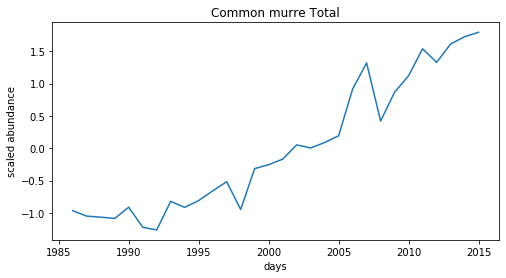

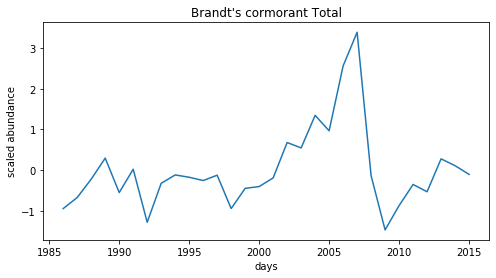

In [5]:
for i, series in enumerate(table.T[1:]):
    fig, ax = plt.subplots(1,figsize=(8,4))
    ax.set_title(df.columns[i+1])
    ax.plot(table[:,0],ns.standardize(series))
    ax.set_ylabel("scaled abundance")
    ax.set_xlabel("days")
    plt.show()

In [108]:
E_max = 4
taus = np.arange(1,5)
r_sqrd_table = np.zeros((len(taus), 2))

In [109]:
for i, series in enumerate(table.T[1:]):
    series = ns.standardize(series)
    r_sqrds = [ns.get_delta_agg(series, E_max, tau=tau,
                             return_forecast_skill=True)[2] 
                   for tau in taus]
    r_sqrd_table[:,i] = r_sqrds
    
np.savetxt("../results/seabird_analysis/seabird_rsqrd_vs_tau.csv", r_sqrd_table, delimiter=",")

In [110]:
# Check Autocorrelation

autocorr_table = np.zeros((len(taus),2))

for i, series in enumerate(table.T[1:]):
    autocorr_table[:,i] = np.array([np.corrcoef(series[tau:],
                                                series[:-tau])[0,1]
                                  for tau in taus])

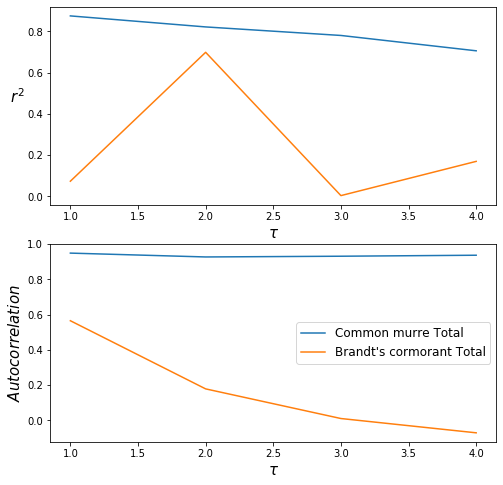

In [111]:
r_sqrd_table = np.loadtxt("../results/seabird_analysis/seabird_rsqrd_vs_tau.csv", delimiter=",")

fig, ax = plt.subplots(2,figsize=(8,8))
for i in range(2):
    ax[0].plot(taus, r_sqrd_table[:,i], label=df.columns[i+1])
    
for i in range(2):
    ax[1].plot(taus, autocorr_table[:,i], label=df.columns[i+1])

ax[0].set_ylabel(r"$r^2$", fontsize = 15, rotation = 0, labelpad=10)
ax[0].set_xlabel(r"$\tau$", fontsize = 15, rotation = 0)

ax[1].set_xlabel(r"$\tau$", fontsize = 15, rotation = 0)
ax[1].set_ylabel(r"$Auto correlation$", fontsize = 15, rotation = 90)

plt.legend(fontsize = 12)

In [112]:
# For the Common murre, we choose tau = 1 as there is no  appreciable drop
# in autocorrelation by increasing it.
# For the Brandt's cormorant, we choose tau = 2 since the autocorrelation drops
# to around 0.2 but the forecast skill jumps up to 0.6

In [113]:
ns.get_delta_agg

<function NSMap.NSMapToolkit.get_delta_agg(Xr, E, tau=1, t=None, trainingSteps=100, return_forecast_skill=False, theta_fixed=False)>

In [8]:
t = table.T[0,:].copy()
t = (t - np.min(t)) / np.ptp(t)

common_murre_series = table.T[1,:]
common_murre_tau = 1
common_murre_E = 6

brandt_cormorant_series = table.T[2,:]
brandt_cormorant_tau = 2
brandt_cormorant_E = 3

In [9]:
delta_agg_murr, theta_agg_murr, r_sqrd_murr = ns.get_delta_agg(common_murre_series, common_murre_E, tau = common_murre_tau, t = t, return_forecast_skill=True)

In [10]:
delta_agg_corm, theta_agg_corm, r_sqrd_corm = ns.get_delta_agg(brandt_cormorant_series, brandt_cormorant_E, tau = brandt_cormorant_tau, t = t, return_forecast_skill=True)

In [11]:
print("Common Murre")
print(f"aggregated delta = {delta_agg_murr:0.3f}, r_sqrd = {r_sqrd_murr:0.3f}")

print("Brandt Cormorant")
print(f"aggregated delta = {delta_agg_corm:0.3f}, r_sqrd = {r_sqrd_corm:0.3f}")

Common Murre
aggregated delta = 0.000, r_sqrd = 0.865
Brandt Cormorant
aggregated delta = 0.000, r_sqrd = 0.630
